# Convolutional Block Attention Module (CBAM)


[reference](https://www.jianshu.com/p/3e33ab049b4e)  
[Paper](https://arxiv.org/pdf/1807.06521.pdf)  
CBAM CNN 注意模組  
相較於SENET只專注於Channel上的權重分配，CBAM多了空間上的權重分布  

![](https://imgur.com/xqAUUM4.png)

In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Input, GlobalAveragePooling2D, Concatenate, multiply, Reshape
from keras.layers import Add, Lambda, GlobalMaxPooling2D, Activation
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.optimizers import adam
from keras.utils import Sequence
from numpy.random import seed 
from tensorflow import set_random_seed 
from keras import backend as K


seed_n = 67

random.seed(seed_n)
os.environ['PYTHONHASHSEED'] = str(seed)
seed(seed_n)
set_random_seed(seed_n)

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Dog vs Cat dataset

利用貓狗數據，自建一組naive的模型當作基準

training_parameter
* epoch = 15  
* optimizer = adam(lr = 0.0005)  
* batch_size = 32
* input_shape = (128,128,3)

In [2]:
ROOT_DIR = os.getcwd()
DATA_PATH = os.path.join(ROOT_DIR, "dogs-vs-cats")
SOURCE_DATA_DIR = os.path.join(DATA_PATH, "train")

print('length of train data %d' %(len(os.listdir(SOURCE_DATA_DIR))))

length of train data 25000


In [3]:
BASE_DIR = os.path.join(DATA_PATH, "VGG_Practice")
if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
    
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
    
TEST_DIR = os.path.join(BASE_DIR, "TEST")
if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)

VAL_DIR = os.path.join(BASE_DIR, "Validation")
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
    
DOG_TRAIN = os.path.join(TRAIN_DIR, "DOG")
if not os.path.exists(DOG_TRAIN):
    os.mkdir(DOG_TRAIN)

CAT_TRAIN = os.path.join(TRAIN_DIR, "CAT")
if not os.path.exists(CAT_TRAIN):
    os.mkdir(CAT_TRAIN)
    
DOG_TEST = os.path.join(TEST_DIR, "DOG")
if not os.path.exists(DOG_TEST):
    os.mkdir(DOG_TEST)
    
CAT_TEST = os.path.join(TEST_DIR, "CAT")
if not os.path.exists(CAT_TEST):
    os.mkdir(CAT_TEST)

    
DOG_VAL = os.path.join(VAL_DIR, "DOG")
if not os.path.exists(DOG_VAL):
    os.mkdir(DOG_VAL)

CAT_VAL = os.path.join(VAL_DIR, "CAT")
if not os.path.exists(CAT_VAL):
    os.mkdir(CAT_VAL)

In [4]:
import shutil

for frame in ['cat.{}.jpg'.format(i) for i in range(0,9000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(0,9000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['cat.{}.jpg'.format(i) for i in range(9001,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['dog.{}.jpg'.format(i) for i in range(9001,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['cat.{}.jpg'.format(i) for i in range(11001,12499)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(11001,12499)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

In [5]:
dataset = './dogs-vs-cats/VGG_Practice/'

train_folder = dataset + 'TRAIN'
val_folder = dataset + 'Validation'
test_folder = dataset + 'TEST'

len(glob.glob(train_folder+'/*/*'))

18000

In [6]:
# normalizing
Imagegen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_datagen = Imagegen.flow_from_directory(
            train_folder,
            target_size=(128,128),
            batch_size=batch_size,
            class_mode='binary'
            )

validation_datagen = Imagegen.flow_from_directory(
            val_folder,
            target_size=(128,128),
            batch_size=batch_size,
            class_mode='binary'
            )

test_datagen = Imagegen.flow_from_directory(
            test_folder,
            target_size=(128,128),
            batch_size=128,
            class_mode='binary',
            shuffle=False
            )

for train_batch, label_batch in train_datagen:
    print('train_batch_shape: ', train_batch.shape)
    print('label_batch_shape: ', label_batch.shape)
    break;

Found 18000 images belonging to 2 classes.
Found 4996 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
train_batch_shape:  (32, 128, 128, 3)
label_batch_shape:  (32,)


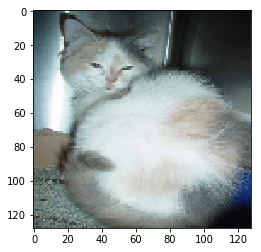

In [7]:
plt.imshow(train_datagen.next()[0][0])

### Model1 naive model

一個簡單的CNN作為基礎網路來做比較

In [8]:
units = 64

Input_L = Input(shape=(128,128,3))
x = Conv2D(units,(3,3),padding='same',activation='relu')(Input_L)
x = BatchNormalization()(x)
x = Conv2D(units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(8*units,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(2*units,activation = 'relu')(x)
x = BatchNormalization()(x)
Output_L = Dense(1,activation = 'sigmoid')(x)

model = Model(Input_L,Output_L)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv

In [9]:
optimizer = adam(lr=0.0005)
model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

In [10]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/naive_base.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

epochs=15
train_history = model.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epochs,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    shuffle=False,
                                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
563/562 [==============================] - 116s 206ms/step - loss: 0.5487 - acc: 0.7212 - val_loss: 0.4935 - val_acc: 0.7606

Epoch 00001: val_acc improved from -inf to 0.76061, saving model to ./dogs-vs-cats/naive_base.model
Epoch 2/15
563/562 [==============================] - 99s 176ms/step - loss: 0.3929 - acc: 0.8229 - val_loss: 0.3456 - val_acc: 0.8437

Epoch 00002: val_acc improved from 0.76061 to 0.84367, saving model to ./dogs-vs-cats/naive_base.model
Epoch 3/15
563/562 [==============================] - 102s 182ms/step - loss: 0.2935 - acc: 0.8716 - val_loss: 0.2513 - val_acc: 0.8977

Epoch 00003: val_acc improved from 0.84367 to 0.89772, saving model to ./dogs-vs-cats/naive_base.model
Epoch 4/15
563/562 [==============================] - 103s 183ms/step - loss: 0.2126 - acc: 0.9120 - val_loss: 0.2664 - val_acc: 0.8907

Epoch 00004: val_acc did not improve from 0.89772
Epoch 5/15
563/562 [=============================

In [11]:
def plot_train_result(train_history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_history.history['loss']), plt.plot(train_history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.title('loss_history')
    plt.xlabel('Epoch'), plt.ylabel('loss',fontsize=20)
    
    plt.subplot(1,2,2)
    plt.plot(train_history.history['acc']), plt.plot(train_history.history['val_acc'])
    plt.legend(['train','validation'])
    plt.title('acc_history')
    plt.xlabel('Epoch'), plt.ylabel('Acc',fontsize=20)
    plt.show()

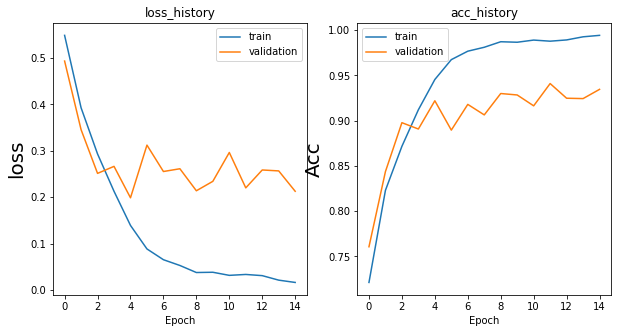

In [12]:
plot_train_result(train_history)

## Model2 - apply SE block

將基礎網路加上SE block來做為第二組網路的比較


In [13]:
def squeeze_excitation_layer(x, channel, ratio = 4):
    squeeze = GlobalAveragePooling2D()(x)
    excitation = Dense(units=channel // ratio, activation='relu')(squeeze)
    excitation = Dense(units=channel, activation='sigmoid')(excitation)
    excitation = Reshape((1,1,channel))(excitation)
    scale = multiply([x,excitation])
    return scale

In [14]:
units = 64

Input_L = Input(shape=(128,128,3))
x = Conv2D(units,(3,3),padding='same',activation='relu')(Input_L)
x = squeeze_excitation_layer(x, units)
x = BatchNormalization()(x)
x = Conv2D(units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 2*units)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 2*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 4*units)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 4*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(8*units,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(2*units,activation = 'relu')(x)
x = BatchNormalization()(x)
Output_L = Dense(1,activation = 'sigmoid')(x)

model2 = Model(Input_L,Output_L)

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 64)           0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           1040        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_5 (D

In [15]:
optimizer = adam(lr=0.0005)
model2.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

In [16]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/SE-naive_best.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

epochs=15
train_history = model2.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epochs,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    shuffle=False,
                                    verbose=1)

Epoch 1/15
563/562 [==============================] - 123s 218ms/step - loss: 0.5560 - acc: 0.7150 - val_loss: 0.4540 - val_acc: 0.7868

Epoch 00001: val_acc improved from -inf to 0.78683, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 2/15
563/562 [==============================] - 119s 211ms/step - loss: 0.4059 - acc: 0.8168 - val_loss: 0.4329 - val_acc: 0.7972

Epoch 00002: val_acc improved from 0.78683 to 0.79724, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 3/15
563/562 [==============================] - 119s 211ms/step - loss: 0.3005 - acc: 0.8710 - val_loss: 0.2964 - val_acc: 0.8727

Epoch 00003: val_acc improved from 0.79724 to 0.87270, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 4/15
563/562 [==============================] - 116s 207ms/step - loss: 0.2101 - acc: 0.9169 - val_loss: 0.2189 - val_acc: 0.9105

Epoch 00004: val_acc improved from 0.87270 to 0.91053, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 5/15
563/562 [===========

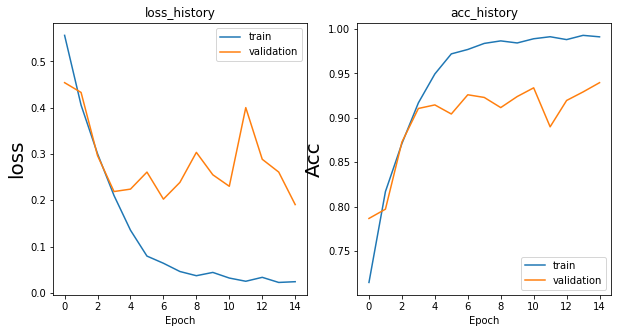

In [17]:
plot_train_result(train_history)

### Model3 apply CBAM block

將base model加上CBAM block來做比較  
首先是channel部分，與SE block相差的是，多利用了globalmaxpooling，額外補充了資訊  
  
空間上的部份，也是利用avg與max兩組資訊，各壓縮唯一通道，在拼接起來成為兩個通道的空間特徵  
在經過一個捲機運算以後乘回去原輸入做為激勵輸出  

![](https://imgur.com/f7DBjKM.png)



在空間與channel上的順序是先channel在spacial  
論文有比較三種拼接方法得到的結果(1. S接C 2. C接S 3. S/C 平行)  
以下是論文提供的結果比較  
![](https://imgur.com/TVP6kwx.png)
![](https://imgur.com/Kv33AqI.png)  


另外看一下resnet上的模型  
![](https://imgur.com/ipThrRs.png)

In [12]:
def cbam_block(cbam_feature, channel, ratio = 4, kernel_size = 7):

    cbam_feature = channel_attention(cbam_feature, channel, ratio)
    cbam_feature = spatial_attention(cbam_feature, kernel_size)
    return cbam_feature

def channel_attention(input_feature, channel, ratio=4):

    shared_layer_one = Dense(channel//ratio, activation='relu')
    shared_layer_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature,kernel_size):

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(filters = 1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          use_bias=False)(concat)

    return multiply([input_feature, cbam_feature])

In [13]:
units = 64

Input_L = Input(shape=(128,128,3))
x = Conv2D(units,(3,3),padding='same',activation='relu')(Input_L)
x = cbam_block(x, units)
x = BatchNormalization()(x)
x = Conv2D(units,(3,3),padding='same',activation='relu')(x)
x = cbam_block(x, units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = cbam_block(x, 2*units)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = cbam_block(x, 2*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = cbam_block(x, 4*units)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = cbam_block(x, 4*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(8*units,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(2*units,activation = 'relu')(x)
x = BatchNormalization()(x)
Output_L = Dense(1,activation = 'sigmoid')(x)

model3 = Model(Input_L,Output_L)

model3.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 64)           0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 64)           0           conv2d_1[0][0]                   
_____________________________________

In [14]:
optimizer = adam(lr=0.0005)
model3.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

In [15]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/CBAM-naive_best.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

epochs=15
train_history = model3.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epochs,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    shuffle=False,
                                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/15
563/562 [==============================] - 185s 329ms/step - loss: 0.6311 - acc: 0.6525 - val_loss: 0.7961 - val_acc: 0.6483

Epoch 00001: val_acc improved from -inf to 0.64832, saving model to ./dogs-vs-cats/CBAM-naive_best.model
Epoch 2/15
563/562 [==============================] - 173s 308ms/step - loss: 0.4768 - acc: 0.7683 - val_loss: 0.6519 - val_acc: 0.7132

Epoch 00002: val_acc improved from 0.64832 to 0.71317, saving model to ./dogs-vs-cats/CBAM-naive_best.model
Epoch 3/15
563/562 [==============================] - 173s 307ms/step - loss: 0.3572 - acc: 0.8464 - val_loss: 0.3885 - val_acc: 0.8163

Epoch 00003: val_acc improved from 0.71317 to 0.81625, saving model to ./dogs-vs-cats/CBAM-naive_best.model
Epoch 4/15
563/562 [==============================] - 215s 381ms/step - loss: 0.2873 - acc: 0.8786 - val_loss: 0.7066 - val_acc: 0.7430

Epoch

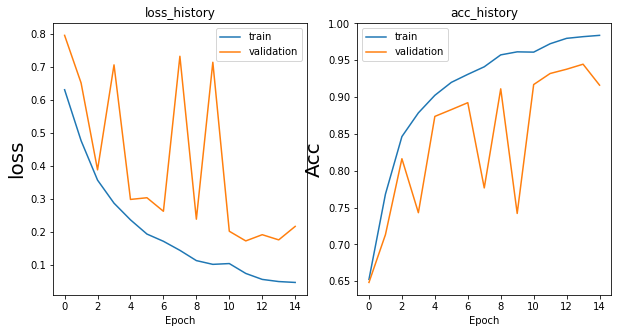

In [18]:
plot_train_result(train_history)

# Result

base model = 89.34  
SE-base model = 90.65  
CBAM-base model = 90.57   

這裡的結果顯示出在SE上與CBAM上的結果都比base model還要更好  
但是CBAM卻只與SENET差不多  
相信是我對於模型的訓練並沒有調整到最佳，訓練的epoch數還不夠  
validation set的loss跳動過大，或許可以在加入learning rate scheduler來幫助收斂...  

總結是在不大幅增加參數的前提下，CBAM能夠提升CNN網路的性能

In [17]:
model_eval = load_model("./dogs-vs-cats/naive_best.model")
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data on naive_best accuracy: %.2f' %(scores[1]*100))

model_eval = load_model("./dogs-vs-cats/SE-naive_best.model")
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy on SE-naive_best model: %.2f' %(scores[1]*100))

model_eval = load_model("./dogs-vs-cats/CBAM-naive_best.model")
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy on CBAM-naive_best model: %.2f' %(scores[1]*100))

test data on naive_best accuracy: 89.34
test data accuracy on SE-naive_best model: 90.65
test data accuracy on CBAM-naive_best model: 90.57


## Summary  
Paper 提供了些成果比較如下

![](https://imgur.com/XgffXnL.png)  


也利用Gram-CAM來視覺化CNN  
可以看到CBAM model在物件上的判斷比起一般的模型能夠更好的捕捉物體  
![](https://imgur.com/B2PCNhb.png)